### Введение

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st 

In [3]:
#Импортируем и посмотрим на датасет
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
#Посмотрим основную иформацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### 1. Подготовка данных

In [6]:
#Приведем навания столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [7]:
#Проверим где есть пропуски и какая доля пропусков в каждом столбце.
(data
    .isna()
    .mean()
    .sort_values(ascending = False)*100)


critic_score       51.319174
rating             40.478612
user_score         40.089740
year_of_release     1.609333
name                0.011965
genre               0.011965
platform            0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
dtype: float64

<AxesSubplot:>

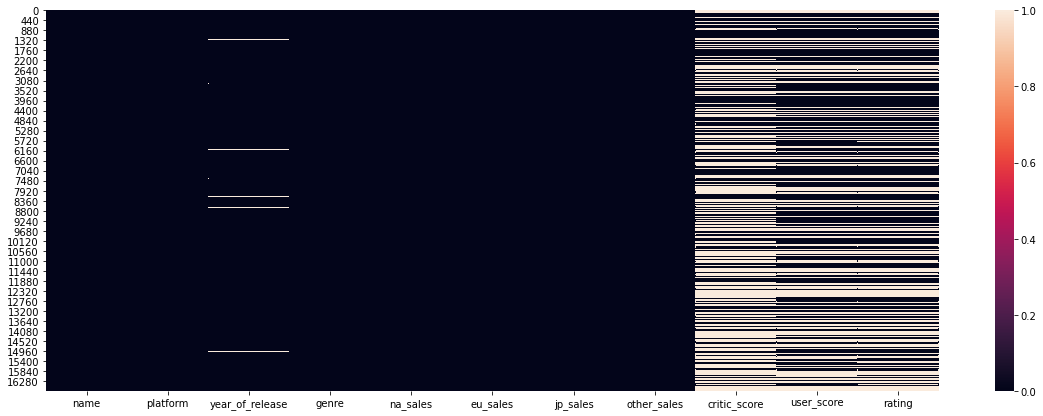

In [8]:
#Попробуем  визуализировать пропуски с помощью прикола, который мне скинул ревьюер на предыдущем проекте
plt.figure(figsize = (20,7))
sns.heatmap(data[data.columns].isnull())

Пропуски присутствуют в основном в столбцах с данными, касающихся оценок игры критиками и игроками а также в столбце с возрастным рейтингом. Думаю вряд ли у какой-либо игры могут отсутствовать оценки игроков или критиков, так что предположу, что пропуски тут обусловлены скорее техническими проблемами при выгрузке данных.
Заменять пропуски на медиану или среднее с привязкой к жанру и платформе не разумно, тк игры в одном жанре и на одной платформе могут быть как хороши так и ужасны. Поэтому пропуски в этих столбцах оставляем как есть.

array([[<AxesSubplot:title={'center':'year_of_release'}>]], dtype=object)

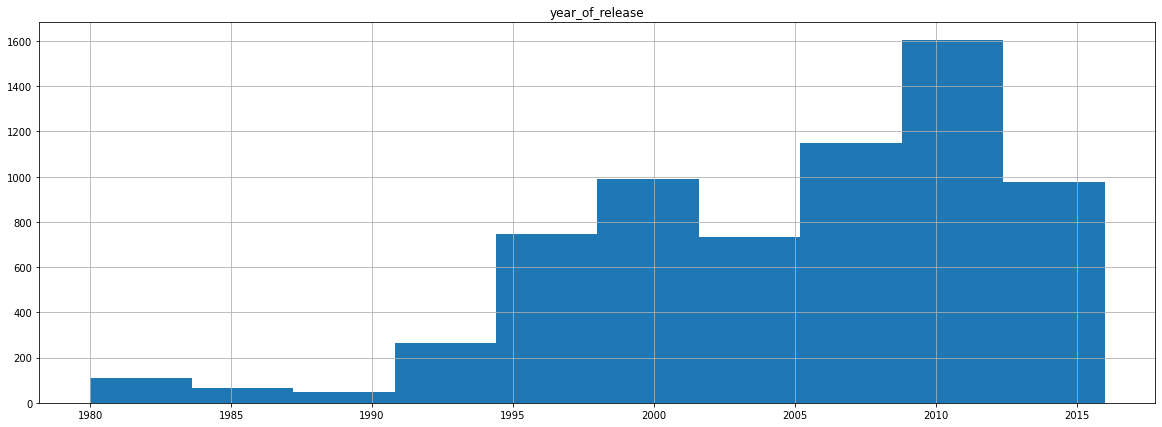

In [9]:
#Посмотрим есть ли какие-то закономерности в пропусках в столбце rating
data.loc[data['rating'].isna(), ['year_of_release']].hist(figsize = (20,7))
#Ничего необычного. Также ставляем пропуски как есть

In [10]:
#Разберемся с tbd
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [11]:
#Гугл говорит, что tbd значит "to be determined" - "подлежит уточнению". Посмотрим, сколько таких значений в таблице
len(data.loc[data['user_score'] == 'tbd'])

2424

Значений `tbd` слишком много чтобы просто их отбросить. Очень хочется заменить на нули, тк логика не нарушается: нет оценки - значит 0, но в столбце также присутствуют пропуски. Поэтому заменим tbd на пропуски, а тип данных в столбце изменим на float. Так как иначе статистика будет искажена, поскольку пропусков и значений `tbd` достаточно много.

In [12]:
data['user_score'] = data['user_score'].replace("tbd", np.nan).astype('float')
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

In [13]:
data['critic_score'] = data['critic_score'].astype('float')

In [14]:
#Доля пропусков в столбце genre и name очень маленькая, так что без сожаления отбросим их
data = data.dropna(subset = ['name', 'genre'])

Доля пропусков в столбце `year_of_release` также не велика, но мы можем восполнить часть данных за счет того, что у некоторых игр указан год выхода только на одной из платформ. Думаю я не ошибусь и не сильно искажу данные, если буду считать, что раз игра выходит на PSV в 2012 году, то на остальные платформы она выходит в тот же год (как, например, в случае с игрой `LEGO Harry Potter: Years 5-7`).

In [15]:
data.loc[data['name'] == 'LEGO Harry Potter: Years 5-7']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1609,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,0.69,0.42,0.0,0.12,76.0,7.8,E10+
2132,LEGO Harry Potter: Years 5-7,X360,NaN,Action,0.51,0.37,0.0,0.09,77.0,7.9,E10+
2273,LEGO Harry Potter: Years 5-7,PS3,NaN,Action,0.36,0.41,0.0,0.15,76.0,8.3,E10+
3081,LEGO Harry Potter: Years 5-7,DS,NaN,Action,0.34,0.25,0.0,0.07,69.0,NaN,E10+
4818,LEGO Harry Potter: Years 5-7,3DS,NaN,Action,0.18,0.19,0.0,0.03,71.0,6.5,E10+
6476,LEGO Harry Potter: Years 5-7,PSP,NaN,Action,0.10,0.10,0.0,0.06,NaN,NaN,E10+
7210,LEGO Harry Potter: Years 5-7,PC,NaN,Action,0.05,0.14,0.0,0.03,80.0,8.5,E10+
8059,LEGO Harry Potter: Years 5-7,PSV,2012.0,Action,0.07,0.07,0.0,0.03,64.0,6.8,E10+


Нужно написать функцию, которая будет искать в данных полные дубликаты по названию игры, у которых год выхода не NaN.

Долго ломал голову как сделать это красиво, но время поджимает, так что буду делать грязь (прости)
Логика такая: 

0. Заполняем пропуски нулями
1. Создаем отдельный набор данных с названиями игр, у которых от сутствует дата выпуска (`no_yor`).
2. Сделаем сделаем срез основного набора данных по названию каждой игры в которой не указана дата выхода.
3. Уберем дубликаты из каждого среза.
4. Те срезы, где после сброса дубликатов размер набора данных будет больше 1 (то есть игра выходиа на все платформы в разные года) отбросим.
5. Из остальных вытащим название игры и год выпуска и положим в соответствующий список
6. Создадим из этих списков набор данных
7. Напишем конструкцию, которая будет искать названия игр из набора данных в п.6 и, если год выпуска пропущен, - заполнять его.

С удовольствием приму совет как сделать это изящнее))

In [16]:
data['year_of_release'] = data['year_of_release'].fillna(0).astype('int')
no_yor = data.loc[data['year_of_release'] == 0, ['name', 'year_of_release']].reset_index(drop = True)

names = []
years = []
for name in no_yor['name'].unique():
    cut = data.loc[data['name'] == name, ['name', 'year_of_release']].drop_duplicates()
    if len(cut.loc[cut['year_of_release'] != 0, ['year_of_release']]) > 1 or len(cut.loc[cut['year_of_release'] != 0, ['year_of_release']]) == 0:
        continue
    else:
        cut = cut.loc[cut['year_of_release'] != 0, ['name', 'year_of_release']].reset_index(drop = True)
        years.append(cut['year_of_release'][0])
        names.append(cut['name'][0])
        

test = pd.DataFrame({
    'name': names,
    'year_of_release': years
})

In [22]:
#Импортируем и посмотрим на датасет
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [24]:
data.columns = data.columns.str.lower()

In [25]:
games_name = data.loc[data['year_of_release'].isna()]['name'].unique()

In [26]:
data.loc[data['name'].isin(games_name)].loc[data['name'] == 'Call of Duty: Black Ops']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
32,Call of Duty: Black Ops,X360,2010.0,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
1131,Call of Duty: Black Ops,PC,NaN,Shooter,0.58,0.81,0.00,0.23,81.0,5.2,M
1412,Call of Duty: Black Ops,Wii,2010.0,Shooter,0.80,0.45,0.00,0.12,80.0,5.8,M
3439,Call of Duty: Black Ops,DS,2010.0,Shooter,0.50,0.04,0.00,0.04,74.0,6,T


In [27]:
MAX_UNIQUE_YEARS = 2
MAX_DIFF_Y = 1

result_df = pd.DataFrame()

for game_name in games_name:
    buffer = data.loc[data['name'] == game_name]
    if buffer['year_of_release'].nunique() > MAX_UNIQUE_YEARS:
        continue
    nan_count = buffer['year_of_release'].isna().sum()
    games_count = buffer['year_of_release'].count()
    
    
    if (nan_count - games_count) <= MAX_DIFF_Y:
        buffer['year_of_release'] = buffer['year_of_release'].fillna(buffer['year_of_release'].max())
        result_df = pd.concat([result_df, buffer])
    

/tmp/ipykernel_67/1940496162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buffer['year_of_release'] = buffer['year_of_release'].fillna(buffer['year_of_release'].max())


In [29]:
result_df.drop_duplicates()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E
377,FIFA Soccer 2004,PS2,2003.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
...,...,...,...,...,...,...,...,...,...,...,...
16405,Freaky Flyers,GC,2003.0,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
12146,Inversion,PS3,2012.0,Shooter,0.03,0.03,0.00,0.01,56.0,5.4,M
12678,Inversion,X360,2012.0,Shooter,0.03,0.02,0.00,0.01,53.0,6.5,M
16448,Inversion,PC,2012.0,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M


In [37]:
result_df.pivot_table(index='name', values='platform',aggfunc='count').sort_values(by='platform',ascending=False)

,platform
name,
Madden NFL 07,9
LEGO Batman: The Videogame,7
LEGO Indiana Jones: The Original Adventures,7
Madden NFL 06,7
Tiger Woods PGA Tour 07,6
...,...
Face Racers: Photo Finish,1
NFL GameDay 2003,1
Famista 64,1


In [39]:
data.loc[data['year_of_release'].isna()].pivot_table(
    index='name', 
    values='platform',
    aggfunc='count',
).sort_values(by='platform',ascending=False)

,platform
name,
LEGO Harry Potter: Years 5-7,7
Rock Band,4
Happy Feet Two,4
WRC: FIA World Rally Championship,3
Test Drive Unlimited 2,3
...,...
Indy 500,1
Inversion,1
James Cameron's Dark Angel,1


In [ ]:
for i in range(0, len(data)):
    if data['year_of_release'][i] == 0:
        for j in range(0, len(test)):
            if data['name'][i] == test['name'][j]:
                data['year_of_release'][i] = test['year_of_release'][j]
            else:
                continue
    else:
        continue

In [ ]:
#Добавим колонку с общими продажами
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

### 2. Исследовательский анализ данных

In [ ]:
#Посмотрим сколько игр выпускалось в разные годы
(data
     .loc[data['year_of_release'] != 0]
     .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'count')
     .reset_index()
     .plot(x = 'year_of_release', 
           kind = 'bar', 
           title = 'Распределение продаж игр по годам',
           label = 'Количество вышедщих игр',
           figsize = (20, 7))
)

На графике видно две точки роста игровой индустрии: с **1994 г.** и с **2000 г.** С 2010 года продажи заметно падают.

Оставим данные начиная с **2000 года**:

In [ ]:
data = data.loc[data['year_of_release'] >= 2000]

Посмотрим, как менялись продажи по платформам.

In [ ]:
#Выберем платформы с самым большим количеством продаж
(data
    .pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
    .sort_values(by = 'total_sales', ascending = True)
    .reset_index()
    .plot(x = 'platform', 
           kind = 'bar', 
           title = 'Распределение продаж игр по платформам',
           label = 'Количество вышедщих игр',
           figsize = (20, 7))
) 

На графике видно, что наиболее популярные платформы начинаются с XB (X-Box). Новые платформы, такие как XOne и PS4 имеют значительно меньшее количество проданных игр. Это связано как и с относительно недавней датой выхода платформы, так и с тем, что в целом, рынок видеоигр падает, начиная с 2010 года и количество выпускаемых игр снижается.

Лидерами по продажам являются платформы:
- PS2
- X-Box 360
- PS3
- Nintendo Wii
- Nintendo DS

In [ ]:
platform_data = (data
                 .pivot_table(index = 'platform', columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
                )


fig, ax = plt.subplots(figsize=(20, 7))
ax.xaxis.tick_top()

sns.heatmap(platform_data, ax = ax,  annot = True, fmt=".0f", cmap="crest")

На графике видно, что в основном, популярные платформы живут в среднем по 7-8 лет. По истечении этого периода, появляется новая, более современная платформа, и интерес к предыдущей версии начинает заметно снижаться.

Топ самых популярных платформ составляют приставки Sony, Microsoft и Nintendo. Рассмотрим подробнее как год от года менялось количество проданных игр у каждой из платформ в каждом семействе, и как менялся спрос на старые модели с выходом более современных.

In [ ]:
data_ps = (data
               .loc[(data['platform'] == 'PS2') | 
                    (data['platform'] == 'PS3') | 
                    (data['platform'] == 'PS4')]
               .pivot_table(index = 'platform', columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
          )

data_ps

In [ ]:
#Приставки Microsoft
data_mic = (data
               .loc[(data['platform'] == 'XB') | 
                    (data['platform'] == 'X360') | 
                    (data['platform'] == 'XOne')]
               .pivot_table(index = 'platform', columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
               .reindex(['XB', 'X360', 'XOne'])
          )

data_mic

In [ ]:
data_nintendo = (data
               .loc[(data['platform'] == 'DS') | 
                    (data['platform'] == '3DS')| 
                    (data['platform'] == 'Wii') | 
                    (data['platform'] == 'WiiU')]
               .pivot_table(index = 'platform', columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
               .reindex(['DS', 'Wii', '3DS', 'WiiU'])
          )
data_nintendo

In [ ]:
for data_cut in [data_ps, data_mic, data_nintendo]:
    fig, ax = plt.subplots(figsize = (20, 3))
    if 'PS' in data_cut.index.all():
        title ='Продажи игр на платформах Play Station'
    elif 'X' in data_cut.index.all():
        title ='Продажи игр на платформах X-Box'
    else:
        title = 'Продажи игр на платформах Nintendo'
    ax.set_title(title, size = 15)
    ax.set_xlabel('Год')
    ax.set_ylabel('Количество проданных игр, млн.копий')
    ax = sns.heatmap(data_cut,
                     annot = True, 
                     fmt=".0f", 
                     cmap="crest")
#Почему-то не добавляются подписи осей. Ну лан

Видно, что c выходом новых платформ, старые теряют популярность, при этом новые платформы с годами не так популярны, чем их предшественники. Это связано с тем, что продажи игр падают по всем платформам, начиная с 2010 года.

Наиболее популярными являются платформы Sony. Далее следуют платформы Nintendo, а затем платформы Microsoft. Причем последняя приставка Sony показывают лучший результат по продажам, чем последние приставки Microsoft и Nintendo вместе взятые.

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.set(ylim=(0, 2))
ax.set_title('Количество продаж по платформам', size = 20)
sns.boxplot(data = data, x = 'platform', y = 'total_sales')

In [ ]:
len(data.loc[data['platform'] =='GB'])

Видим много выбросов практически у всех платформ. Выбросы - это игры, которые продались болшим тиражом.Больше всего таких игр у платформ Nintendo.

Медианные продажи у консолей выше, чем у PC. Самые большие медианные продажи у X-Box 360 и PS3.
Самые большие медианные продажи у платформы Game Boy, однако их всего 27 в этом наборе данных.
Разобьем платформы по семействам и сравним в продажи в каждом семействе платформ:

In [ ]:
def get_platform_family(row):
    if 'PS' in row:
        return 'Sony'
    elif 'X' in row:
        return 'Microsoft'
    elif ('Wii' in row) or ('DS' in row) or ('3DS' in row):
        return 'Nintendo'
    elif row == 'PC':
        return 'PC'
    else:
        return 'idk'

data['platform_family'] = data['platform'].apply(get_platform_family)

fig, ax = plt.subplots(figsize = (20, 10))
ax.set(ylim=(0, 1.5))
ax.set_title('Количество продаж по семействам платформ', size = 20)
sns.boxplot(data = data, x = 'platform_family', y = 'total_sales')

Медианные продажи приставок Microsoft самые высокие. У Nintendo есть какая-то супер выстрелившая игра (наверное какой-нибудь марио), а PC игроки, похоже не очень любят покупать игры 🏴‍☠️🏴‍☠️🏴‍☠️

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Рассмотрим PS3:

In [ ]:
sns.pairplot(data.loc[data['platform'] == "PS3"][['total_sales', 'critic_score', 'user_score']])
plt.show()

Видно, что оценки критиков достаточно сильно влияют на продажи игр на PS3, а оценки игроков наоборот, практически не оказывают никакого влияния на продажи. Однако есть игры, имеющие высокие оценки от игроков, но не имеющие такого количества продаж, как игры, высоко оцененные критиками. 

Оценки игр критиками и игроками весьма сильно зависят друг от друга. Это разумно. Хорошую игру одинаково хвалят критики и игроки.

In [ ]:
data.loc[data['platform'] == "PS3"][['total_sales', 'critic_score', 'user_score']].corr()

Значения коэффициентов коррелиции Пирсона подтверждают выводы выше.

Оценим распределение игр по жанрам:

In [ ]:
genre_data = (data
                  .pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum')
                  .sort_values('total_sales' ,ascending = False)
                  .reset_index()
             )

fig, ax = plt.subplots(figsize = (20, 7))
ax.set_title('Распределение продаж игр по жарнам', size = 20)
sns.barplot(
    data=genre_data,
    x = 'genre', 
    y='total_sales',
    palette="pastel", 
    edgecolor=".6"
)

Пять самых популярных жанров:
* Action
* Sports
* Shooter
* Role - Playing
* Misc

### 3. Портрет пользователя каждого региона

In [ ]:
#Топ 5 платформ:
NA_plt = (data
              .pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')
              .sort_values('na_sales', ascending = False)
              .head(5)
              .reset_index())

EU_plt = (data
              .pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')
              .sort_values('eu_sales', ascending = False)
              .head(5)
              .reset_index())

JP_plt = (data
              .pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')
              .sort_values('jp_sales', ascending = False)
              .head(5)
              .reset_index())

In [ ]:
#Топ 5 жанров:
NA_gnr = (data
              .pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
              .sort_values('na_sales', ascending = False)
              .head(5)
              .reset_index())

EU_gnr = (data
              .pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
              .sort_values('eu_sales', ascending = False)
              .head(5)
              .reset_index())

JP_gnr = (data
              .pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
              .sort_values('jp_sales', ascending = False)
              .head(5)
              .reset_index())

In [ ]:
#Платформы
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(NA_plt['platform'], NA_plt['na_sales'])
ax1.set_title("Северная Америка", size = 15)
ax1.set_ylim([0, 700])

ax2.bar(EU_plt['platform'], EU_plt['eu_sales'])
ax2.set_title("Европа", size = 15)
ax2.set_ylim([0, 700])

ax3.bar(JP_plt['platform'], JP_plt['jp_sales'])
ax3.set_title("Япония", size = 15)
ax3.set_ylim([0, 700])

plt.show()

По абсолютному числу продаж лидирует Северная Америка.

В Северной Америке и Европе популярны одни и те же платформы. В Северной Америке самой популярной платформой является X-Box 360, а в Европе - PS2.

В Японии самыми популярнми платформами являются (сюрприз) Японские игровые платформы. Самая популярная платформа - Nintendo DS.

In [ ]:
#Жанры
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(NA_gnr['genre'], NA_gnr['na_sales'])
ax1.set_title("Северная Америка", size = 15)
ax1.set_ylim([0, 800])

ax2.bar(EU_gnr['genre'], EU_gnr['eu_sales'])
ax2.set_title("Европа", size = 15)
ax2.set_ylim([0, 800])

ax3.bar(JP_gnr['genre'], JP_gnr['jp_sales'])
ax3.set_title("Япония", size = 15)
ax3.set_ylim([0, 800])

plt.show()

Популярные жанры в Сервеной Америке и Европе совпадают. С тем отличием, что в Америке предпочитают RPG, а в Европе - гонки. Популярные жарны в Японии не совпадают с остальными рассматриаемыми регионами. Самы популярный жанр - RPG. 

In [ ]:
data['rating'].unique()

In [ ]:
def translate_esrb_rating(row):
    if row == 'E' or row == 'EC':
        return 'Для детей'
    elif row == 'T' or row == 'E10+':
        return 'Для подростков'
    elif row == 'AO' or row == 'RP' or row == 'M':
        return 'Для взрослых'
    
data['rating_po_ludski'] = data['rating'].apply(translate_esrb_rating)
data['rating_po_ludski'].unique()

In [ ]:
#Возрастной рейтинг
fig, axs = plt.subplots(ncols=3,
                       figsize=(20, 5))
axs[0].set(ylim=(0, 1.5))
axs[1].set(ylim=(0, 0.8))
axs[2].set(ylim=(0, 0.1))


axs[0].set_title("Северна Америка", size = 15)
axs[1].set_title("Европа", size = 15)
axs[2].set_title("Япония", size = 15)

sns.boxplot(x= data['rating'], y= data['na_sales'], data=data, ax=axs[0])
sns.boxplot(x= data['rating'], y= data['eu_sales'], data=data, ax=axs[1])
sns.boxplot(x= data['rating'], y= data['jp_sales'], data=data, ax=axs[2])

Во всех странах по продажам лидируют игры с рейитнгом "M" - для взрослых. Этот рейтинг используется,когда присутствуют сцены насилия. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или наркотиков.

В Японии основную часть рынка видеоигр составляют игры с рейтингом M - дл взрослых и T - для детей от 13 лет. Игр с другими возрастными рейтингами значительно меньше, однако и в них есть игры, с достаточно большим количеством продаж.

### 4. Проверка гипотез

Проверим гипотезу **"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые."**


**H0 (нулевая гипотеза)**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**H1 (альтернативная гипотеза)**: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.

In [ ]:
xone = data.loc[(data['platform'] == 'XOne') & ~(data['user_score'].isna()), ['user_score']]
xone.hist()

In [ ]:
pc = data.loc[(data['platform'] == 'PC') & ~(data['user_score'].isna()), ['user_score']]
pc.hist()

In [ ]:
#Критичский уровень значимости примем 0,05
alpha = .05 

#Так как мы проверяем гипотезу о равенстве средних двух генеральных совокупностей (все оценки игроков всех игр на XOne и PC),
#то выбираем метод ttest_ind
#Не очень понимаю, нужно ли указывать параметр equal_var и как оценить дисперсии двух генеральных совокупностей по выборкам.
#Наверное они, скорее - всего равны, но, полагаю, что нужна проверка и вывод, подвержденный ицфрой, а не предположение
result_platform = st.ttest_ind(
    xone, 
    pc)

print('p-value:', result_platform.pvalue)


if (result_platform.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не достаточно оснований отвергнуть нулевую гипотезу.") 

Вероятность получить такое или более выраженное отличие средних двух генеральных совокупностей меньше критического уровня значимости (крайне мала), поэтому отвергаем нулевую гипотезу.

![KRAYNE MALA](http://sun9-41.userapi.com/impf/c627718/v627718013/15a00/qcASs9jzXnY.jpg?size=468x468&quality=96&sign=c1fdcb71f14440b37da9d15e65ba330b&type=album)

Проверим гипотезу **"Средние пользовательские рейтинги жанров Action и Sports разные."**


**H0 (нулевая гипотеза)**: Средние пользовательские рейтинги двух жанров разные.

**H1 (альтернативная гипотеза)**: Средние пользовательские рейтинги двух жанров одинаковые.

In [ ]:
action = data.loc[(data['genre'] == 'Action') & ~(data['user_score'].isna()), ['user_score']]
action.hist()

In [ ]:
sports = data.loc[(data['genre'] == 'Sports') & ~(data['user_score'].isna()), ['user_score']]
sports.hist()

In [ ]:
#Критичский уровень значимости примем 0,05
alpha = .05 

result_genre = st.ttest_ind(
    action, 
    sports
    )

print('p-value:', result_genre.pvalue)


if (result_genre.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не достаточно оснований отвергнуть нулевую гипотезу.") 

Вероятность получить такое или более выраженное отличие средних двух генеральных совокупностей достаточно высока, поэтому у нас недостаточно оснований утверждать, что средние пользовательские рейтинги жанров Action и Sports разные. 

### 5. Вывод.

Изучен набор данных о продажах видеоигр на разных платформах.

Из набора данных видно, что с 2000 по 2010 год игровая индустрия активро развивалась, а после 2010 года продажи начали падать. Выяснилось, что игровые консоли живут как правило 8 лет, после чего выходит либо более современная модель в этом семействе консолей, либо интерес к рассматриваемой консоли начинает падать.

Активнее всего продаются консоли Sony и Microsoft. На обхемыпродаж в бОльшей степени влияют отзывы критоков, чем отзывы игроков. Однако низкие оценки критиков не дают продаваться играм в большом объеме, в то время как низкие оценки игроков не мешают продаваться играм большим количеством копий.
Самые популярный жанры - **Action, Sports, Shooter, Role - Playing, Misc.**

* В Америке предпочитают игры жанра **Action** а также платформу **X-Box 360**
* В Европе жанровые предпочтения аналогичны Американским, но самая популярная платформа - **PS**.
* В Японии предпочитают приставки **Nintendo** и игры жанра **Role-Playing**.

Самые популярные игры с возрастным рейтингом **"Для взрослых"** и **"Для подростков"**. В Японии игры с этими возрастными рейтингами представлены в бОльшем объеме, по сравнению с остальными.

Были проверены следующие гипотезы (критический уровень значимости - 0,05):

**"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые."** - гипотеза не подтвердилась (p-value = 0.0000375)

**"Средние пользовательские рейтинги жанров Action и Sports разные."** - гипотеза подтвердилась (p-value = 0.0906)